# Glaze et al (2015): Normative evidence accumulation in unpredictable environments

# Recap

Last session we saw what a continous, integrating model looks like. The drift diffusion model (DDM) takes into account a drift parameter along with previous data (finish the clause). The Ornstein-Uhlenbeck (O-U) model extended the pure DDM with anothe free parameter to "leak" previously seen data, effectively giving the model memory.

Glaze et al. (2015) reintroduces volatility into the model while extending on this leaky accumulation concept. Additionally, the Glaze model introduces non-absorbing bounds, so that hazard rate can change intra-task and can be evaluated contiunously and in real-time. The DDM and O-U models "stop" once the accumulation hits a pre-defined bound, while the Glaze model asymptotically accumulates the new information.

## Model Comparison

|Feature|Pure DDM|O-U|Glaze|
|---|---|---|---|
|Accumulation|Perfect Integration|Leaky Integration|Adaptive (Leaky -> Stable)|
|Key Parameter|Drift (A)|Leak (lambda) + Drift (A)|Hazard Rate (H)|
|Boundaries|Absorbing (Stop)|Absorbing (Stop)|Non-Absorbing (Monitor)|
|Handling Volatility|Fails (Integrates noise)|Constant Leak (Fixed adaptation)|Dynamic Leak (Adapts to H)|

## Our Glaze Demo
Try the triangle task yourself **[at this link](https://foo.bar/)**.

![qrcode_glaze-triangles-task-986109366512.us-west1.run.app.png](AHH)

# Getting Started

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from scipy.optimize import minimize_scalar

## Generate synthetic data

In [ ]:
# --- 1. Generate Synthetic Data (The Environment) ---
np.random.seed(42)
n_trials = 200
H_true = 0.1  # The "Objective Hazard Rate" (Probability of switch per trial)
noise_std = 1.0

# Generate true state (1 or -1) switching with probability H
true_state = np.zeros(n_trials)
current_state = 1
for t in range(n_trials):
    if np.random.rand() < H_true:
        current_state *= -1 # Switch state
    true_state[t] = current_state

# Generate noisy sensory evidence (Log Likelihood Ratios - LLR)
# In this simulation, positive LLR supports state 1, negative LLR supports state -1
# This assumes Gaussian noise around the signal.
evidence = np.random.normal(loc=true_state, scale=noise_std)
LLR = evidence  # Simplified: assuming LLR is proportional to raw evidence

# Plot the environment
plt.figure(figsize=(12, 2))
plt.plot(true_state, label='True State', color='black', linestyle='--')
plt.bar(range(n_trials), LLR, color='gray', alpha=0.5, label='Noisy Evidence (LLR)')
plt.title("The Environment: Hidden State and Noisy Evidence")
plt.legend()
plt.show()

# I. The Perfect Accumulator

$$ L_n = L_{n-1} + LLR_n $$

This represents perfect integration where $ H = 0 $, the environment is fully stable.

## Implementation

In [ ]:
def perfect_accumulator(llrs):
    """
    Standard Drift Diffusion / Perfect Integration.
    Assumes H = 0 (Stability).
    """
    ns = len(llrs)
    L = np.zeros(ns)

    for n in range(1, ns):
        raise NotImplementedError("Remove this exception and implement the line below")
        # L[n] =

    return L

<details>
<summary><b>Show solution</b></summary>

```python
def perfect_accumulator(llrs):
    """
    Standard Drift Diffusion / Perfect Integration.
    Assumes H = 0 (Stability).
    """
    ns = len(llrs)
    L = np.zeros(ns)

    for n in range(1, ns):
        L[n] = L[n-1] + llrs[n]

    return L
```

## Visualization

In [ ]:
L_perfect = perfect_accumulator(LLR)

plt.figure(figsize=(12, 3))
plt.plot(L_perfect, label='Perfect Accumulator (DDM)', color='red')
plt.plot(true_state * 50, 'k--', label='True State (Scaled)', alpha=0.3) # Scaled for visibility
plt.title("The Problem with Perfect Integration (Unbounded)")
plt.ylabel("Belief (L)")
plt.xlabel("Time")
plt.legend()
plt.show()

# II. The Normative model (Discrete-time model)


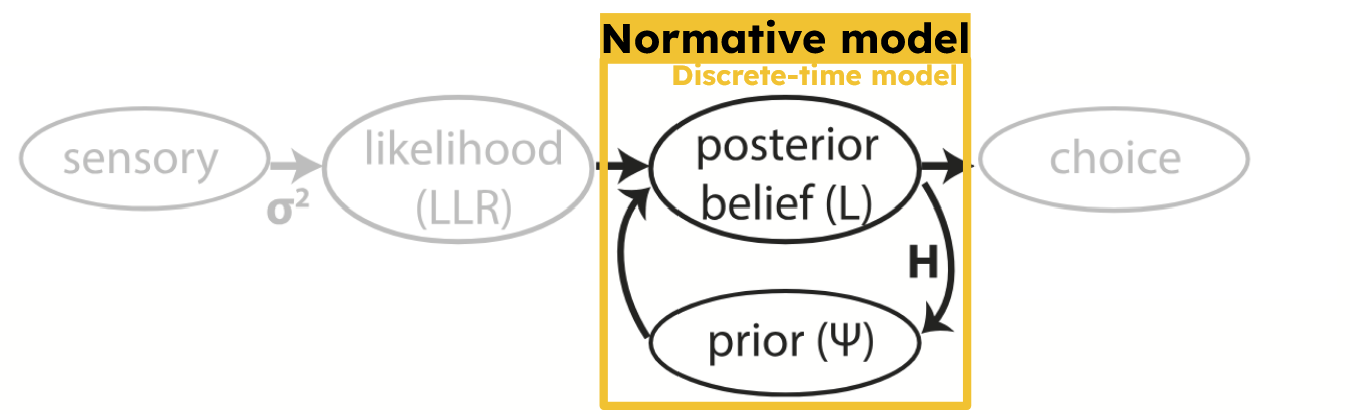

As we have seen in the presentation, the posterior belief $L$ is defined as:

$$ L_n = \psi(L_{n-1}, H) + LLR_n $$

The Prior expectation function $\psi$ transforms the previous belief based on the hazard rate before adding new evidence.

$$ \psi(L_{n-1}, H) = L_{n-1} + \log\left[\frac{1-H}{H} + \exp(-L_{n-1})\right] - \log\left[\frac{1-H}{H} + \exp(L_{n-1})\right] $$

**_Hint:_** use `np.exp` and `np.log` for calculating exponentials and natural logarithms respectively.

## Implementation

In [ ]:
def psi_function(L_prev, H):
    """
    The non-linear prior expectation function from Glaze et al. (2015).
    This function distorts the previous belief based on the hazard rate.
    """
    # Prevent numerical overflow for very large L
    # If L is huge, the prior is just the bound (see Part 3)
    if abs(L_prev) > 100:
        return np.sign(L_prev) * np.log((1-H)/H)

    raise NotImplementedError("Remove this exception and implement the line below")
    # expectation =

    return expectation

def glaze_model(llrs, H):
    ns = len(llrs)
    L = np.zeros(ns)

    for n in range(1, ns):
        # 1. Calculate Prior Expectation (The "Psi" function)
        prior = psi_function(L[n-1], H)

        # 2. Update with new evidence
        L[n] = prior + llrs[n]

    return L

<details>
<summary><b>Show solution</b></summary>

```python
def psi_function(L_prev, H):
    """
    The non-linear prior expectation function from Glaze et al. (2015).
    This function distorts the previous belief based on the hazard rate.
    """
    # Prevent numerical overflow for very large L
    # If L is huge, the prior is just the bound (see Part 3)
    if abs(L_prev) > 100:
        return np.sign(L_prev) * np.log((1-H)/H)

    # The Exact Equation (Eq 2 in Glaze 2015)
    term1 = (1 - H) / H
    term_pos = term1 + np.exp(-L_prev)
    term_neg = term1 + np.exp(L_prev)

    expectation = L_prev + np.log(term_pos) - np.log(term_neg)

    return expectation

def glaze_model(llrs, H):
    ns = len(llrs)
    L = np.zeros(ns)

    for n in range(1, ns):
        # 1. Calculate Prior Expectation (The "Psi" function)
        prior = psi_function(L[n-1], H)

        # 2. Update with new evidence
        L[n] = prior + llrs[n]

    return L
```

## Visualization

In [ ]:
def plot_glaze_model_interactive(H):
    L_glaze = glaze_model(LLR, H=H)

    plt.figure(figsize=(12, 3))
    plt.plot(L_glaze, label='Glaze Normative Model', color='green')
    plt.plot(true_state * 5, 'k--', label='True State (Scaled)', alpha=0.3)
    plt.title(f"Part 2: The Normative Solution (Adaptive Beliefs) with H={H:.2f}")
    plt.ylabel("Belief (L)")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

h_slider_glaze = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=0.99,
    step=0.01,
    description='Hazard Rate (H):',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

widgets.interactive(plot_glaze_model_interactive, H=h_slider_glaze)

# III. The Continuous-Time Model

$$ dL(t) = \left[ -2\lambda \sinh(L(t)) \right] dt + A dx(t) $$

**_Hint:_** use `np.sinh` for calculating hyperbolic sine.

## Implementation

In [ ]:
def continuous_glaze_model(evidence_stream, lambda_rate, dt=0.01):
    """
    Continuous time implementation using Euler integration.
    lambda_rate: The change rate (hazard rate in continuous time)
    """
    n_steps = len(evidence_stream)
    L = np.zeros(n_steps)

    for t in range(1, n_steps):
        # Previous state
        L_prev = L[t-1]

        # The Non-linear "Filter" Term (Leak + Bound dynamics)
        raise NotImplementedError("Remove this exception and implement the line below")
        # deterministic_change =

        # New evidence (Drift + Noise)
        # Note: In discrete simulation, 'evidence_stream' represents A*dx
        raise NotImplementedError("Remove this exception and implement the line below")
        # new_evidence =

        # Update
        L[t] = L_prev + deterministic_change + new_evidence

    return L

<details>
<summary><b>Show solution</b></summary>

```python
def continuous_glaze_model(evidence_stream, lambda_rate, dt=0.01):
    """
    Continuous time implementation using Euler integration.
    lambda_rate: The change rate (hazard rate in continuous time)
    """
    n_steps = len(evidence_stream)
    L = np.zeros(n_steps)

    for t in range(1, n_steps):
        # Previous state
        L_prev = L[t-1]

        # The Non-linear "Filter" Term (Leak + Bound dynamics)
        deterministic_change = -2 * lambda_rate * np.sinh(L_prev) * dt

        # New evidence (Drift + Noise)
        # Note: In discrete simulation, 'evidence_stream' represents A*dx
        new_evidence = evidence_stream[t] * dt

        # Update
        L[t] = L_prev + deterministic_change + new_evidence

    return L
```

## Visualization

In [ ]:
def plot_continuous_glaze_model_interactive(lambda_rate, dt):
    L_continuous = continuous_glaze_model(evidence, lambda_rate=lambda_rate, dt=dt)

    plt.figure(figsize=(12, 3))
    plt.plot(L_continuous, label='Continuous Normative Model', color='purple')
    plt.plot(true_state * 3, 'k--', label='True State (Scaled)', alpha=0.3)
    plt.title(f"Part 4: Continuous Time Dynamics (Lambda={lambda_rate:.2f}, dt={dt:.2f})")
    plt.xlabel("Time (t)")
    plt.ylabel("Belief (L)")
    plt.legend()
    plt.show()

lambda_slider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=1.0,
    step=0.01,
    description='Lambda Rate (H):',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

dt_slider = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=1.0,
    step=0.01,
    description='dt (Time Step):',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

widgets.interactive(plot_continuous_glaze_model_interactive, lambda_rate=lambda_slider, dt=dt_slider)

# IV. Discrete vs. Continuous

The following graphic shows a visual representation of the application of the Glaze model in both discrete and continuous timescales together.

As briefly questioned during the DDM session, discrete and continuous models can be seen as two sides of the same coin. The computational model will ultimately treat continuous data as discretized.

An important distinction, however, is in the power of the Glaze model to predict normative behavior in both timescales from "one" equation.

It will be noted that the dots task data was in fact computed using the discrete equation by the authors.

## Visualization

In [ ]:
# --- 1. Fake Data Generation ---
np.random.seed(42) # For consistent plotting

# Macro Data (Triangles): Discrete "Step" changes
# Represents belief updating only when a star appears (Eq. 1)
macro_steps = 8
macro_x = np.arange(macro_steps)
macro_y = np.cumsum(np.random.choice([-2, 2, -1, 1], size=macro_steps))

# Micro Data (Dots): Continuous "Noisy" flow
# Represents accumulation of motion energy in milliseconds (Eq. 4)
micro_steps = 200
micro_x = np.linspace(0, 1, micro_steps)
# Simulate noisy accumulation (brownian motion)
micro_y = np.cumsum(np.random.randn(micro_steps) * 0.2)

# --- 2. Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5) # Add space for the zoom lines

# === Top Panel: Triangles (Macro) ===
ax1.set_title("Macro Scale: Triangles Task (Discrete Updates)", loc='left', weight='bold')
ax1.set_ylabel("Belief ($L$)")
ax1.set_xlabel("Time (Seconds/Trials)")

# Plot step function (belief holds steady, then jumps)
ax1.step(macro_x, macro_y, where='post', color='black', linewidth=2)
# Plot "Stars" (discrete evidence samples)
ax1.plot(macro_x, macro_y, 'o', color='#E67E22', markersize=8, label='Discrete Sample')

# === Bottom Panel: Dots (Micro) ===
ax2.set_title("Micro Scale: Dots Task (Continuous Flow)", loc='left', weight='bold')
ax2.set_ylabel("Belief ($L$)")
ax2.set_xlabel("Time (Milliseconds)")

# Plot noisy continuous accumulation
ax2.plot(micro_x, micro_y, color='#2980B9', linewidth=1.5, label='Motion Energy')
ax2.fill_between(micro_x, micro_y, alpha=0.2, color='#2980B9') # Visual flair

# === 3. The "Zoom" Connection ===
# We visually connect one "step" from the top graph to the whole bottom graph.
# Let's zoom into the interval between time step 2 and 3.
zoom_start = 2
zoom_end = 3

# Draw lines connecting the top box to the bottom axes
# Connect bottom-left of top box to top-left of bottom plot
con1 = ConnectionPatch(xyA=(zoom_start, -2), coordsA=ax1.transData,
                       xyB=(0, 1), coordsB=ax2.transAxes, color='red', linestyle=':', linewidth=1.5)
# Connect bottom-right of top box to top-right of bottom plot
con2 = ConnectionPatch(xyA=(zoom_end, -2), coordsA=ax1.transData,
                       xyB=(1, 1), coordsB=ax2.transAxes, color='red', linestyle=':', linewidth=1.5)

fig.add_artist(con1)
fig.add_artist(con2)

# --- 4. Annotations ---
# Text explaining the Glaze 2015 finding
ax1.text(0.5, 1.15, "Glaze Eq 1: $L_n = \psi(L_{n-1}, H) + LLR_n$",
         transform=ax1.transAxes, ha='center', color='gray', fontsize=10)
ax2.text(0.5, 1.15, "Glaze Eq 4: $dL = -2\lambda \sinh(L)dt + Adx$",
         transform=ax2.transAxes, ha='center', color='gray', fontsize=10)

plt.show()

# V. Linear Approximations

## Leaky Accumulation (Low Certainty)

The Glaze paper shows us how for certain H values the model collapses into much simpler forms.

When the belief L is close to 0 (uncertain), the model acts like a linear leaky accumulator.

$$ \psi(L_{n-1}, H) \approx (1 - 2H) \cdot L_{n-1} \quad \text{for} \quad L_{n-1} \approx 0 $$

In [ ]:
def leaky_approximation_model(llrs, H):
    """
    Implements the leaky approximation model for belief updating.
    L_n = (1 - 2H) * L_{n-1} + LLR_n
    """
    ns = len(llrs)
    L = np.zeros(ns)

    for n in range(1, ns):
        L[n] = (1 - 2 * H) * L[n-1] + llrs[n]

    return L

## Stabilizing Bound (High Certainty)

When the belief L is strong, the prior saturates at a specific bound determined by the hazard rate.

$$ \psi(L_{n-1}, H) \approx \text{sgn}(L_{n-1}) \log\left(\frac{1-H}{H}\right) \quad \text{for} \quad |L_{n-1}| \gg 0 $$

In [ ]:
def plot_update_dynamics(H):
    """
    Visualizes the Psi function against the approximations
    to teach 'Leak' vs 'Bound'.
    """
    # Create a range of previous beliefs (from very negative to very positive)
    L_prev_range = np.linspace(-10, 10, 500)

    # 1. Calculate the full Normative update (Psi)
    psi_values = [psi_function(l, H) for l in L_prev_range]

    # 2. Approximation A: The Linear Leak (Slope < 1)
    # Equation: (1 - 2H) * L
    leak_slope = (1 - 2 * H)
    leak_values = leak_slope * L_prev_range

    # 3. Approximation B: The Stabilizing Bound (Asymptote)
    # Equation: log((1-H)/H)
    bound_value = np.log((1 - H) / H)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot Identity line (Perfect Accumulator) for comparison
    plt.plot(L_prev_range, L_prev_range, 'k--', alpha=0.2, label='Perfect Memory (Slope=1)')

    # Plot Normative Psi
    plt.plot(L_prev_range, psi_values, 'g-', linewidth=3, label='Normative Prior ($\psi$)')

    # Plot Approximations
    plt.plot(L_prev_range, leak_values, 'b:', label=f'Approximation A: Leak (Slope={leak_slope:.2f})')
    plt.axhline(bound_value, color='r', linestyle=':', label=f'Approximation B: Bound (+{bound_value:.2f})')
    plt.axhline(-bound_value, color='r', linestyle=':')

    plt.title(f"The Mechanism (Hazard Rate H={H})")
    plt.xlabel("Previous Belief ($L_{n-1}$)")
    plt.ylabel("Prior Expectation ($\psi$)")
    plt.ylim(-6, 6)
    plt.xlim(-6, 6)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the visualization
plot_update_dynamics(H=0.1)

# VI. Comparing Models

Now that we have code for the various models, let's see how they compare against your triangle task data.

## Load personal data

Once you've run an experiment in our triangles task demo you can paste it here and review the model behavior.

Click `Copy Choice CSV` from the analysis page of the triangles task demo and paste it into the `student_data` variable below.

In [ ]:
student_data = """
"""

<details>
<summary><b>Further sample data/CSV format</b></summary>

```python
student_data = """
block_id,trial_index,hazard_rate,LLR,choice,correct_side
1,1,0.05,9.880645,1,1
1,2,0.05,10.657655,1,1
1,3,0.05,9.765958,1,1
1,4,0.05,5.986321,1,1
1,5,0.05,7.612862,1,1
1,6,0.05,7.982518,1,1
1,7,0.05,13.991888,1,1
1,8,0.05,11.405244,1,1
1,9,0.05,13.048711,1,1
1,10,0.05,10.662507,1,1
1,11,0.05,3.803042,1,1
1,12,0.05,5.350738,1,1
1,13,0.05,5.629313,1,1
1,14,0.05,5.306885,1,1
1,15,0.05,10.493614,1,1
1,16,0.05,10.519666,1,1
1,17,0.05,10.258499,1,1
1,18,0.05,9.154030,1,1
1,19,0.05,12.837061,1,1
1,20,0.05,4.898916,1,1
1,21,0.05,7.117478,1,1
1,22,0.05,8.019548,1,1
1,23,0.05,3.832509,1,1
1,24,0.05,10.569502,1,1
1,25,0.05,-12.005862,0,0
1,26,0.05,-10.611910,0,0
1,27,0.05,-13.972471,0,0
1,28,0.05,-9.881410,0,0
1,29,0.05,0.678641,0,0
1,30,0.05,-9.240914,0,0
1,31,0.05,-5.475543,0,0
1,32,0.05,-9.365653,0,0
1,33,0.05,-13.357812,0,0
1,34,0.05,-13.742126,0,0
1,35,0.05,-10.824728,0,0
1,36,0.05,0.621195,0,0
1,37,0.05,-11.461215,0,0
1,38,0.05,-2.283438,0,0
1,39,0.05,-15.625000,0,0
1,40,0.05,-2.575744,0,0
2,1,0.1,-0.919783,0,1
2,2,0.1,-13.454392,0,0
2,3,0.1,-10.928223,0,0
2,4,0.1,-10.493573,0,0
2,5,0.1,-8.730135,0,0
2,6,0.1,-8.566714,0,0
2,7,0.1,-8.927087,0,0
2,8,0.1,-2.541781,0,0
2,9,0.1,4.507728,1,1
2,10,0.1,8.727856,1,1
2,11,0.1,5.411976,1,1
2,12,0.1,7.296775,1,1
2,13,0.1,-3.274099,1,0
2,14,0.1,-5.136966,0,0
2,15,0.1,-4.770159,0,0
2,16,0.1,-6.062019,0,0
2,17,0.1,-7.793055,0,0
2,18,0.1,-5.211287,0,0
2,19,0.1,-13.479367,0,0
2,20,0.1,-7.018608,0,0
2,21,0.1,2.360583,1,0
2,22,0.1,11.047524,1,1
2,23,0.1,6.615221,1,1
2,24,0.1,11.375792,1,1
2,25,0.1,15.625000,1,1
2,26,0.1,1.818637,1,1
2,27,0.1,5.217444,1,1
2,28,0.1,15.625000,1,1
2,29,0.1,-7.689160,0,0
2,30,0.1,9.412259,1,1
2,31,0.1,9.295159,1,1
2,32,0.1,13.079496,1,1
2,33,0.1,4.655334,1,1
2,34,0.1,6.805838,1,1
2,35,0.1,4.458326,1,1
2,36,0.1,8.667143,1,1
2,37,0.1,13.061337,1,1
2,38,0.1,0.909619,1,1
2,39,0.1,11.825610,1,1
2,40,0.1,6.782010,1,1
3,1,0.3,-3.293856,0,0
3,2,0.3,3.563788,1,1
3,3,0.3,3.682168,1,1
3,4,0.3,8.504486,1,1
3,5,0.3,7.668212,1,1
3,6,0.3,6.785313,1,1
3,7,0.3,12.464229,1,1
3,8,0.3,-7.738626,0,0
3,9,0.3,9.746188,1,1
3,10,0.3,9.315846,1,1
3,11,0.3,9.362093,1,1
3,12,0.3,7.536788,1,1
3,13,0.3,9.605104,1,1
3,14,0.3,-2.203272,0,1
3,15,0.3,-15.625000,0,0
3,16,0.3,-7.862694,0,0
3,17,0.3,-15.625000,0,0
3,18,0.3,-12.031652,0,0
3,19,0.3,6.409422,1,1
3,20,0.3,-1.888646,0,1
3,21,0.3,12.136394,1,1
3,22,0.3,7.916448,1,1
3,23,0.3,10.001397,1,1
3,24,0.3,7.331518,1,1
3,25,0.3,-7.689815,0,0
3,26,0.3,-7.872556,0,0
3,27,0.3,-9.806421,0,0
3,28,0.3,-8.165903,0,0
3,29,0.3,-8.624597,0,0
3,30,0.3,-1.582356,0,0
3,31,0.3,-11.956889,0,0
3,32,0.3,9.232821,1,1
3,33,0.3,4.588970,1,1
3,34,0.3,-10.599354,0,0
3,35,0.3,-14.063305,0,0
3,36,0.3,-13.386371,0,0
3,37,0.3,8.527772,1,1
3,38,0.3,12.225307,1,1
3,39,0.3,1.395957,1,1
3,40,0.3,-2.299116,0,0
4,1,0.5,-7.255499,0,0
4,2,0.5,1.886132,1,0
4,3,0.5,15.625000,1,1
4,4,0.5,9.323378,1,1
4,5,0.5,-7.673851,0,0
4,6,0.5,-12.187023,0,0
4,7,0.5,-9.296256,0,0
4,8,0.5,-4.102889,0,0
4,9,0.5,-11.434695,0,0
4,10,0.5,-5.994351,0,0
4,11,0.5,6.177154,1,1
4,12,0.5,-6.238711,0,0
4,13,0.5,-5.193898,0,0
4,14,0.5,12.859509,1,1
4,15,0.5,-5.874964,0,0
4,16,0.5,9.735231,1,1
4,17,0.5,5.659828,1,1
4,18,0.5,15.431813,1,1
4,19,0.5,-4.167284,0,0
4,20,0.5,1.786078,0,1
4,21,0.5,1.024434,0,1
4,22,0.5,8.770229,1,1
4,23,0.5,-5.467776,0,0
4,24,0.5,10.690435,1,1
4,25,0.5,9.488603,1,1
4,26,0.5,-8.521731,0,0
4,27,0.5,13.592578,1,1
4,28,0.5,-6.908615,0,0
4,29,0.5,11.006283,1,1
4,30,0.5,-4.453987,0,0
4,31,0.5,2.158412,0,1
4,32,0.5,12.863531,1,1
4,33,0.5,-4.032055,0,0
4,34,0.5,2.626014,1,1
4,35,0.5,-6.381782,0,0
4,36,0.5,-15.625000,0,0
4,37,0.5,14.203706,1,1
4,38,0.5,13.468411,1,1
4,39,0.5,4.971236,1,1
4,40,0.5,9.444920,1,1
"""
```

These helper functions are used to estimate subjective H using a grid search approach for various H values and the cross-entropy error minimization, much more tractable than full blown gradient descent for our purposes.

In [ ]:
def update_belief(prev_belief, llr, h):
    # This is the stable math version of Glaze Eq 1 [Source 757]
    term1 = prev_belief + np.log((1 - h) / h + np.exp(-prev_belief))
    term2 = np.log((1 - h) / h + np.exp(prev_belief))
    return term1 - term2 + llr

def cost_function(h, llrs, choices):
    belief = 0
    total_error = 0
    for i in range(len(llrs)):
        belief = update_belief(belief, llrs[i], h)

        # Convert belief to probability of choosing Left (1)
        # Using sigmoid approximation for choice probability
        p_left = 1 / (1 + np.exp(-belief))

        # Avoid log(0) errors
        p_left = np.clip(p_left, 1e-9, 1 - 1e-9)

        # If user chose Left (1), error is -log(p_left)
        # If user chose Right (0), error is -log(1 - p_left)
        if choices[i] == 1:
            total_error -= np.log(p_left)
        else:
            total_error -= np.log(1 - p_left)

    return total_error

## Comparison

Now to plot the models...

In [ ]:
if len(student_data) <= 1:
  raise ValueError("You gotta load triangle task data into `student_data` above!")

### Subjective H Comparison

In [ ]:
split_data = student_data.strip().split('\n')
df = pd.DataFrame([trial.split(',') for trial in split_data[1:]], columns=split_data[0].split(','))

# Convert 'LLR' and 'choice' columns to numeric types
df['LLR'] = pd.to_numeric(df['LLR'])
df['choice'] = pd.to_numeric(df['choice'])
df['correct_side'] = pd.to_numeric(df['correct_side'])

def plot_subjective_h_comparison(block_id):
    block_data = df[df['block_id'] == block_id]
    llrs = block_data['LLR'].values

    # Re-running minimization to get the best_fit_h for the current block
    choices = block_data['choice'].values
    correct_sides = block_data['correct_side'].values # Get correct_side data

    result = minimize_scalar(cost_function, bounds=(0.001, 0.999), args=(llrs, choices), method='bounded')
    current_best_fit_h = result.x

    # Calculate beliefs for each model
    L_perfect = perfect_accumulator(llrs)
    L_glaze = glaze_model(llrs, H=current_best_fit_h)
    L_leaky_approx = leaky_approximation_model(llrs, H=current_best_fit_h)

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(L_perfect, label='Perfect Accumulator (DDM)', color='red', linestyle='--')
    plt.plot(L_glaze, label=f'Glaze Normative Model (H={current_best_fit_h:.3f})', color='green')
    plt.plot(L_leaky_approx, label=f'Leaky Approximation (H={current_best_fit_h:.3f})', color='blue', linestyle=':')

    # Scale correct_side to be visible on the same y-axis as beliefs.
    # Assuming beliefs can range, let's scale correct_side (0 or 1) to -5 or 5 for example
    # This is a heuristic scale, adjust as needed based on the range of L values.
    scaled_correct_side = (correct_sides * 10) - 5 # Transform 0 to -5, 1 to 5
    plt.step(range(len(correct_sides)), scaled_correct_side, where='mid', color='purple', linestyle='-', alpha=0.6, label='Correct Side (Scaled)')

    plt.title(f"Belief Updating Models Comparison for Block {block_id} (Symmetric Log Scale)")
    plt.ylabel("Belief (L) / Correct Side (Scaled)")
    plt.xlabel("Trial Number")
    plt.yscale('symlog', linthresh=0.1) # Apply symmetric log scale, with a linear region near 0
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

unique_block_ids = df['block_id'].unique().tolist()
default_block_id = unique_block_ids[0] if unique_block_ids else None

block_id_dropdown_subjective = widgets.Dropdown(
    options=unique_block_ids,
    value=default_block_id,
    description='Block ID:',
)

widgets.interactive(plot_subjective_h_comparison, block_id=block_id_dropdown_subjective)

### Arbitrary H Comparison

In [ ]:
def plot_glaze_and_leaky_interactive(H, block_id):
  # Ensure student_data is loaded and parsed
  if not student_data.strip():
      print("Please load triangle task data into `student_data` to visualize.")
      return

  split_data = student_data.strip().split('\n')
  df = pd.DataFrame([trial.split(',') for trial in split_data[1:]], columns=split_data[0].split(','))
  df['LLR'] = pd.to_numeric(df['LLR'])
  df['choice'] = pd.to_numeric(df['choice'])
  df['correct_side'] = pd.to_numeric(df['correct_side'])

  # Filter data for the selected block_id
  current_block_data = df[df['block_id'] == block_id]
  llrs = current_block_data['LLR'].values
  correct_sides = current_block_data['correct_side'].values

  # Calculate beliefs for Glaze and Leaky Approximation models using the custom H
  L_perfect = perfect_accumulator(llrs)
  L_glaze = glaze_model(llrs, H=H)
  L_leaky_approx = leaky_approximation_model(llrs, H=H)

  # Scale correct_side to be visible on the same y-axis as beliefs.
  # This is a heuristic scale, adjust as needed based on the range of L values.
  scaled_correct_side = (correct_sides * 10) - 5 # Transform 0 to -5, 1 to 5

  plt.figure(figsize=(8, 4))
  plt.plot(L_perfect, label='Perfect Accumulator (DDM)', color='red', linestyle='--')
  plt.plot(L_glaze, label=f'Glaze Normative Model (H={H:.2f})', color='green')
  plt.plot(L_leaky_approx, label=f'Leaky Approximation (H={H:.2f})', color='blue', linestyle=':')
  plt.step(range(len(correct_sides)), scaled_correct_side, where='mid', color='purple', linestyle='-', alpha=0.6, label='Correct Side (Scaled)')

  plt.title(f"Glaze vs. Leaky Approximation for Block {block_id} with Custom H={H:.2f}")
  plt.ylabel("Belief (L) / Correct Side (Scaled)")
  plt.xlabel("Trial Number")
  plt.yscale('symlog', linthresh=0.1) # Apply symmetric log scale
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

# Create the slider for H
h_custom_slider = widgets.FloatSlider(
    value=0.1,  # Default starting value for H
    min=0.01,
    max=0.99,
    step=0.01,
    description='Custom Hazard Rate (H):',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Extract unique block_ids from student_data for the dropdown
# This part needs to be executed to get the unique block_ids
if student_data.strip():
    split_data = student_data.strip().split('\n')
    df = pd.DataFrame([trial.split(',') for trial in split_data[1:]], columns=split_data[0].split(','))
    unique_block_ids = df['block_id'].unique().tolist()
    # Set default to the first block if available
    default_block_id = unique_block_ids[0] if unique_block_ids else None
else:
    unique_block_ids = []
    default_block_id = None

block_id_dropdown = widgets.Dropdown(
    options=unique_block_ids,
    value=default_block_id,
    description='Block ID:',
)

# Display the interactive plot
widgets.interactive(plot_glaze_and_leaky_interactive, H=h_custom_slider, block_id=block_id_dropdown)